In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch

np.random.seed(0)
torch.manual_seed(0)

In [3]:
from tslearn.datasets import UCR_UEA_datasets

# Load dataset (Replace 'DatasetName' with your actual dataset)
ucr = UCR_UEA_datasets(use_cache=True)
X_train, y_train, X_test, y_test = ucr.load_dataset(
    "UWaveGestureLibrary"
)  # Good dataset : Epilepsy, UWaveGestureLibrary, HandMovementDirection

X_train.shape

/opt/homebrew/Caskroom/miniforge/base/envs/ciel/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


(120, 315, 3)

In [4]:
from sklearn.preprocessing import MinMaxScaler

batch_size, seq_len, n_dim = X_train.shape
test_batch_size = X_test.shape[0]

scl = MinMaxScaler()

X_train_reshaped = X_train.reshape(-1, n_dim)
X_test_reshaped = X_test.reshape(-1, n_dim)

X_train_scaled = scl.fit_transform(X_train_reshaped)
X_test_scaled = scl.transform(X_test_reshaped)

X_train = X_train_scaled.reshape(batch_size, seq_len, n_dim)
X_test = X_test_scaled.reshape(test_batch_size, seq_len, n_dim)

In [5]:
y_train = y_train.astype(float).astype(int)
y_test = y_test.astype(float).astype(int)

In [6]:
import sys

sys.path.append("..")

In [7]:
from torch_mas.batch.trainer import DTWTrainer, BaseTrainer, KnowTrainer
from torch_mas.batch.internal_model import NClass
from torch_mas.batch.activation_function import BaseActivation, DTWActivation
from torch_mas.data import DataBuffer

_, seq_len, input_dim = X_train.shape

internal_nodel = NClass(
    input_dim=input_dim,
    output_dim=1,
    memory_length=input_dim + 1,
)

activation = BaseActivation(
    seq_len=seq_len, input_dim=input_dim, output_dim=1, alpha=0.1, neighbor_rate=0.9
)

trainer = KnowTrainer(
    activation,
    internal_nodel,
    R=0.1,
    bad_th=0.01,
    n_epochs=10,
)

dataset = DataBuffer(X_train, y_train)

trainer.fit(dataset)
trainer.n_agents

120

In [8]:
import torch
from sklearn.metrics import accuracy_score


y_pred = trainer.predict(torch.tensor(X_test, dtype=torch.float32))
# print(y_pred, y_test)
print(f"Nombre de points prédits : {y_pred[~torch.isnan(y_pred)].shape[0]}")
print(accuracy_score(y_pred[~torch.isnan(y_pred)], y_test[~torch.isnan(y_pred)]))

Nombre de points prédits : 1
1.0


tensor(3.) green
tensor(1.) red
tensor(4.) purple
tensor(4.) purple
tensor(1.) red


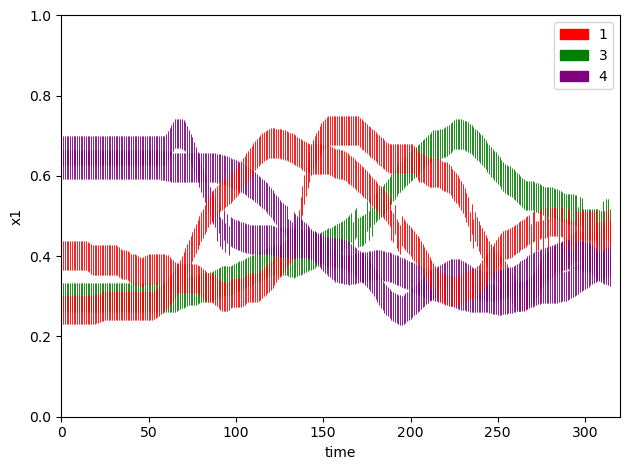

In [9]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as mpatches


fig, ax = plt.subplots()
colors = ["red", "blue", "green", "purple", "orange", "grey", "magenta", "brown"]

# activation.orthotopes is a tensor of size (n_agents, seq_len, n_dim, 2)
orthotopesdim0 = activation.orthotopes[:5, :, 0, :]

for agent_id in range(orthotopesdim0.shape[0]):
    y = internal_nodel.base_prediction[agent_id]
    print(y, colors[int(y - 1)])

    lines = []
    for time in range(orthotopesdim0[agent_id].shape[0]):
        for h in range(orthotopesdim0[agent_id][time].shape[0]):
            lines.append(
                [
                    (time, orthotopesdim0[agent_id][time][0]),
                    (time, orthotopesdim0[agent_id][time][1]),
                ]
            )

    lc = LineCollection(lines, colors=colors[int(y - 1)], linewidths=0.5, alpha=0.9)
    ax.add_collection(lc)

ax.set_xlim(0, 320)
plt.xlabel("time")
plt.ylabel("x1")
red_patch = mpatches.Patch(color="red", label="1")
green_patch = mpatches.Patch(color="green", label="3")
orange_patch = mpatches.Patch(color="purple", label="4")
ax.legend(handles=[red_patch, green_patch, orange_patch])
plt.tight_layout()
plt.show()

In [10]:
(activation.orthotopes[:, :10, :, 1] - activation.orthotopes[:, :10, :, 0]).mean(
    dim=-1
).shape

torch.Size([120, 10])

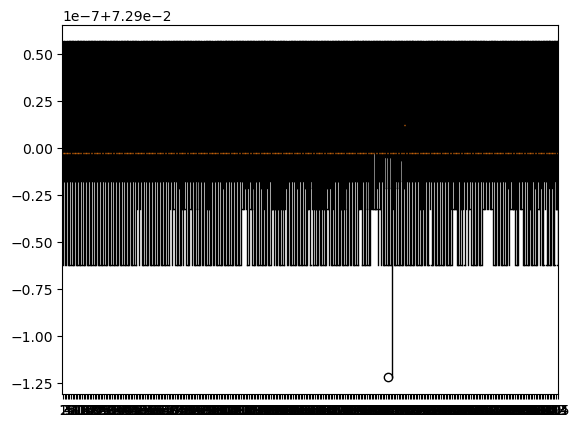

In [11]:
plt.boxplot((activation.orthotopes[:, 0:, 1, 1] - activation.orthotopes[:, 0:, 1, 0]))
plt.show()

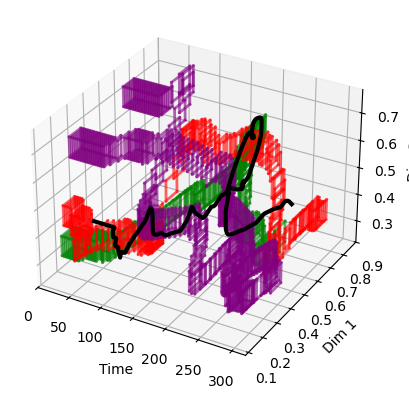

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# %matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

colors = ["red", "blue", "green", "purple", "orange", "grey", "magenta", "brown"]

# activation.orthotopes is a tensor of size (n_agents, seq_len, n_dim, 2)
orthotopesdim0 = activation.orthotopes[:4, :, 0, :]
orthotopesdim1 = activation.orthotopes[:4, :, 1, :]  # Using second spatial dimension

for agent_id in range(orthotopesdim0.shape[0]):
    y = internal_nodel.base_prediction[agent_id]

    for time in range(0, orthotopesdim0.shape[1], 3):
        x = time  # Time axis
        z_min, z_max = orthotopesdim0[agent_id, time]
        y_min, y_max = orthotopesdim1[agent_id, time]

        # Vertical lines in 3D (connecting min/max bounds)
        ax.plot(
            [x, x],
            [y_min, y_min],
            [z_min, z_max],
            color=colors[int(y - 1)],
            linewidth=2,
            alpha=0.6,
        )
        ax.plot(
            [x, x],
            [y_max, y_max],
            [z_min, z_max],
            color=colors[int(y - 1)],
            linewidth=2,
            alpha=0.6,
        )

        # Horizontal lines in the Z direction
        ax.plot(
            [x, x],
            [y_min, y_max],
            [z_min, z_min],
            color=colors[int(y - 1)],
            linewidth=2,
            alpha=0.6,
        )
        ax.plot(
            [x, x],
            [y_min, y_max],
            [z_max, z_max],
            color=colors[int(y - 1)],
            linewidth=2,
            alpha=0.6,
        )

time = np.linspace(0, 315, 315)  # Time steps (Z-axis)

ts0 = X_train[1, :, 0]
ts1 = X_train[1, :, 1]

ax.plot3D(time, ts0, ts1, color="black", linewidth=3, label="3D Signal")

ax.set_xlim(0, 320)
ax.set_xlabel("Time")
ax.set_ylabel("Dim 1")
ax.set_zlabel("Dim 2")

plt.show()

In [13]:
def hyperrectangle_volume(a):
    return torch.prod(a[:, 1] - a[:, 0])


def intersection_volume(a1, a2):
    inter_lower = torch.maximum(a1[:, 0], a2[:, 0])
    inter_upper = torch.minimum(a1[:, 1], a2[:, 1])

    if torch.any(inter_lower >= inter_upper):
        return 0.0
    return torch.prod(inter_upper - inter_lower)


orthotopes = trainer.activation.orthotopes
base_prediction = trainer.internal_model.base_prediction
seq_len = trainer.activation.orthotopes.shape[1]


superpositions = torch.zeros((trainer.n_agents, trainer.n_agents))

for i, a1 in enumerate(orthotopes):
    for j, a2 in enumerate(orthotopes):
        mean_coverage = torch.zeros(seq_len)
        for t in range(seq_len):

            vol_A = hyperrectangle_volume(a1[t])
            vol_intersection = intersection_volume(a1[t], a2[t])

            mean_coverage[t] = (vol_intersection / vol_A) * 100 if vol_A != 0 else 0

        superpositions[i][j] = torch.mean(mean_coverage)

In [14]:
superpositions.shape

torch.Size([120, 120])

In [15]:
to_plot = []

onlyc1 = superpositions[base_prediction == 1][:, base_prediction != 1]
onlyc1 = onlyc1[onlyc1.sum(dim=-1) != 0]

<BarContainer object of 15 artists>

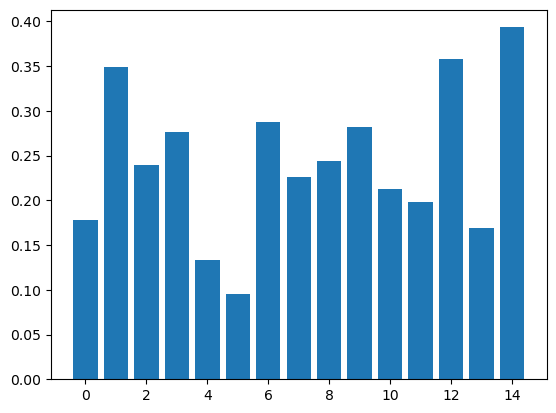

In [16]:
plt.bar(
    torch.arange(0, 15),
    onlyc1.mean(dim=-1),
)

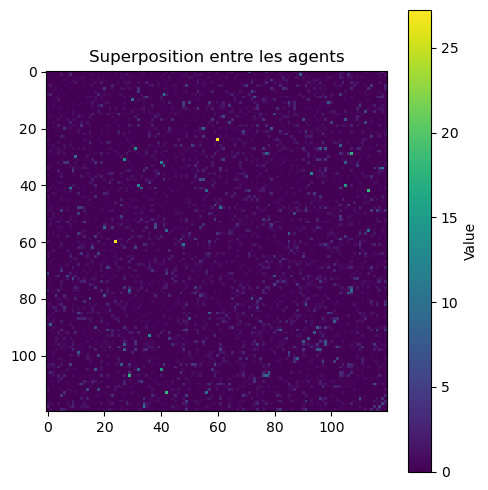

In [17]:
import numpy as np
import matplotlib.pyplot as plt

idx = torch.arange(superpositions.size(0))  # Index vector for diagonal
superpositions[idx, idx] = 0

plt.figure(figsize=(5, 5))
plt.imshow(superpositions, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Value")
plt.title("Superposition entre les agents")
plt.tight_layout()
plt.show()

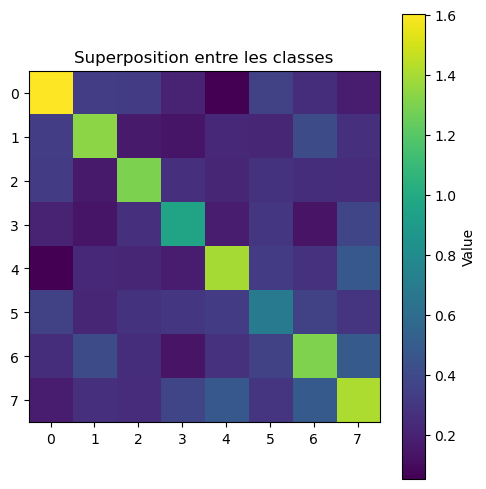

In [18]:
superpositions_between_classes = torch.zeros(
    (base_prediction.unique().size(0), base_prediction.unique().size(0))
)

for i, c1 in enumerate(base_prediction.unique()):
    tmp = superpositions[base_prediction == c1]
    res = []
    for j, c2 in enumerate(base_prediction.unique()):
        superpositions_between_classes[i][j] = tmp[:, base_prediction == c2].mean()


plt.figure(figsize=(5, 5))
plt.imshow(superpositions_between_classes, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Value")
plt.title("Superposition entre les classes")
plt.tight_layout()
plt.show()

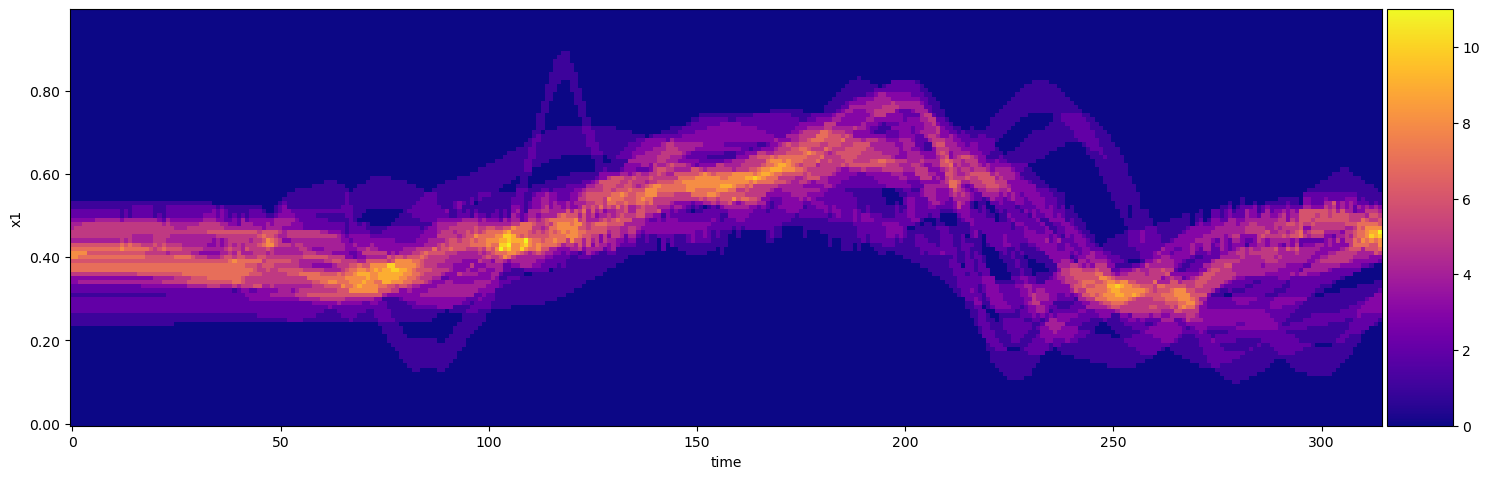

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker


def intersect_point(hypercube, x):
    return (x < hypercube[1]) & (x > hypercube[0])


batch_intersect_point = torch.vmap(intersect_point, in_dims=(0, None))


def create_heatmap(fig, ax, dim, orthotopes):
    heatmap = torch.zeros((100, 315))
    x = torch.arange(0, 100)
    y = torch.arange(0, 315)
    xx, yy = torch.meshgrid(x, y)
    zz = torch.stack((xx, yy), dim=-1).flatten(start_dim=0, end_dim=1)

    for x, y in zz:
        orthotopes_ts = orthotopes[:, y]
        heatmap[x, y] += batch_intersect_point(
            orthotopes_ts[:, dim][base_prediction == 1], x / 100
        ).sum()

    im = ax.imshow(heatmap, cmap="plasma", interpolation="nearest", origin="lower")
    # ax.set_title(f"{dim}")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, orientation="vertical")
    ax.set_xlabel("time")
    ax.set_ylabel("x1")

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f"{y/100:.2f}"))


fig, axs = plt.subplots(1, 1, figsize=(15, 10))
# for dim in range(orthotopes.size(2)):
# create_heatmap(fig, axs[dim], dim, orthotopes)

create_heatmap(fig, axs, 0, orthotopes)
plt.tight_layout()
plt.show()